In [44]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import warnings
warnings.filterwarnings('ignore')

In [45]:
df = pd.read_csv('heart_cleaned.csv')
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289.0,0,172,0,0.0,False,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,0,160,180.0,0,156,0,1.0,True,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,1,130,283.0,0,98,0,0.0,False,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48,0,138,214.0,0,108,1,1.5,True,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,54,1,150,195.0,0,122,0,0.0,False,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [46]:
class FeatureCategorizer:
    def __init__(self, df):
        self.df = df.copy()
        self.continuous_features = []
        self.binary_features = []
        
    def categorize_features(self):
        """Automatically categorize features as continuous or binary"""
        print("Analyzing features...")
        print("="*50)
        
        for col in self.df.columns:
            unique_vals = self.df[col].nunique()
            is_numeric = pd.api.types.is_numeric_dtype(self.df[col])
            unique_values = sorted(self.df[col].unique())
            
            print(f"\n{col}:")
            print(f"  - Unique values: {unique_vals}")
            print(f"  - Is numeric: {is_numeric}")
            print(f"  - Sample values: {unique_values[:5] if len(unique_values) > 5 else unique_values}")
            
            if is_numeric:
                if unique_vals == 2 or set(self.df[col].unique()).issubset({0, 1, 0.0, 1.0}):
                    self.binary_features.append(col)
                    print(f"  → Classified as: BINARY")
                else:
                    self.continuous_features.append(col)
                    print(f"  → Classified as: CONTINUOUS")
            else:
                # Handle boolean or string binary features
                if unique_vals == 2:
                    self.binary_features.append(col)
                    print(f"  → Classified as: BINARY")
                else:
                    print(f"  → Classified as: OTHER (will be ignored)")
        
        print(f"\n{'='*50}")
        print("FINAL CATEGORIZATION:")
        print(f"{'='*50}")
        print(f"Continuous features ({len(self.continuous_features)}): {self.continuous_features}")
        print(f"Binary features ({len(self.binary_features)}): {self.binary_features}")
        
        return self.continuous_features, self.binary_features
    
    def get_feature_stats(self):
        """Get detailed statistics for each feature type"""
        print(f"\n{'='*50}")
        print("FEATURE STATISTICS:")
        print(f"{'='*50}")
        
        if self.continuous_features:
            print("\nCONTINUOUS FEATURES:")
            for feature in self.continuous_features:
                data = self.df[feature]
                print(f"\n{feature}:")
                print(f"  Mean: {data.mean():.2f}")
                print(f"  Std:  {data.std():.2f}")
                print(f"  Min:  {data.min():.2f}")
                print(f"  Max:  {data.max():.2f}")
                print(f"  Q1:   {data.quantile(0.25):.2f}")
                print(f"  Q3:   {data.quantile(0.75):.2f}")
        
        if self.binary_features:
            print("\nBINARY FEATURES:")
            for feature in self.binary_features:
                value_counts = self.df[feature].value_counts()
                print(f"\n{feature}:")
                for val, count in value_counts.items():
                    percentage = (count / len(self.df)) * 100
                    print(f"  {val}: {count} ({percentage:.1f}%)")

# Categorize features
categorizer = FeatureCategorizer(df)
continuous_features, binary_features = categorizer.categorize_features()

# Get detailed statistics
categorizer.get_feature_stats()

Analyzing features...

Age:
  - Unique values: 50
  - Is numeric: True
  - Sample values: [np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32)]
  → Classified as: CONTINUOUS

Sex:
  - Unique values: 2
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(1)]
  → Classified as: BINARY

RestingBP:
  - Unique values: 67
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(80), np.int64(92), np.int64(94), np.int64(95)]
  → Classified as: CONTINUOUS

Cholesterol:
  - Unique values: 222
  - Is numeric: True
  - Sample values: [np.float64(85.0), np.float64(100.0), np.float64(110.0), np.float64(113.0), np.float64(117.0)]
  → Classified as: CONTINUOUS

FastingBS:
  - Unique values: 2
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(1)]
  → Classified as: BINARY

MaxHR:
  - Unique values: 119
  - Is numeric: True
  - Sample values: [np.int64(60), np.int64(63), np.int64(67), np.int64(69), np.int64(70)]
  → Classified as: CONTINUOUS

ExerciseAngina

In [47]:
from sklearn.feature_selection import mutual_info_classif

X = df.drop('HeartDisease', axis=1)
Y = df['HeartDisease']

mutua_informazione_feature = []

def analyze_feature_information(X, Y, continuous_features, binary_features):
    """
    Calcola la mutual information media per feature numeriche e binarie.
    
    Args:
        X (pd.DataFrame): dataset delle feature
        y (pd.Series o array): target
        numerical_features (list): lista nomi delle feature numeriche
        binary_features (list): lista nomi delle feature binarie
    
    Returns:
        dict: valori medi di mutual information
    """
    # Calcolo mutual information per tutte le feature
    mi = mutual_info_classif(X, Y, discrete_features='auto', random_state=42)
    mi_df = pd.DataFrame({
        "feature": X.columns,
        "mutual_info": mi
    })
    
    # Separazione numeriche e binarie
    mi_numerical = mi_df[mi_df["feature"].isin(continuous_features)]["mutual_info"].mean()
    mi_binary = mi_df[mi_df["feature"].isin(binary_features)]["mutual_info"].mean()
    
    return {
        "MI_numerical": mi_numerical,
        "MI_binary": mi_binary
    }

ris = analyze_feature_information(X, Y, continuous_features, binary_features)
print(ris)

{'MI_numerical': np.float64(0.06646737346489448), 'MI_binary': np.float64(0.06725815612608918)}


In [48]:
def introduce_missing_values(df: pd.DataFrame, columns: list, percentage: float) -> pd.DataFrame:
    """
    Introduce una percentuale specifica di valori mancanti (NaN) in determinate colonne di un DataFrame.
    La funzione originale è corretta e la manteniamo così com'è.

    Args:
        df (pd.DataFrame): Il DataFrame di input.
        columns (list): La lista dei nomi delle colonne in cui inserire i NaN.
        percentage (float): La percentuale di valori da sostituire (es. 0.10 per il 10%).

    Returns:
        pd.DataFrame: Un nuovo DataFrame con i valori mancanti.
    """
    df_degraded = df.copy()
    for col in columns:
        non_missing_indices = df_degraded[col].dropna().index
        n_to_make_missing = int(len(non_missing_indices) * percentage)
        
        missing_indices = np.random.choice(
            non_missing_indices, 
            size=n_to_make_missing, 
            replace=False
        )
        df_degraded.loc[missing_indices, col] = np.nan

    return df_degraded

# --- Esempio Pratico di Utilizzo ---

# 2. DEFINIZIONE DEI PARAMETRI
# Selezioniamo tutte le feature tranne la variabile target
features_to_degrade = df.columns.drop("HeartDisease")

# Creiamo la lista di percentuali progressive da 5% a 50%
missing_percentages = np.arange(0.05, 0.51, 0.05).round(2)

# Impostiamo un seme per la riproducibilità dell'esperimento
np.random.seed(42)

# 3. GENERAZIONE DEI DATASET DEGRADATI IN UN CICLO
# Usiamo un dizionario per mappare ogni percentuale al suo dataset degradato
degraded_datasets = {}

for p in missing_percentages:
    print(f"Generando dataset con {int(p*100)}% di valori mancanti...")
    degraded_datasets[p] = introduce_missing_values(
        df=df,
        columns=features_to_degrade,
        percentage=p
    )

print("\nGenerazione completata! ✅")

Generando dataset con 5% di valori mancanti...
Generando dataset con 10% di valori mancanti...
Generando dataset con 15% di valori mancanti...
Generando dataset con 20% di valori mancanti...
Generando dataset con 25% di valori mancanti...
Generando dataset con 30% di valori mancanti...
Generando dataset con 35% di valori mancanti...
Generando dataset con 40% di valori mancanti...
Generando dataset con 45% di valori mancanti...
Generando dataset con 50% di valori mancanti...

Generazione completata! ✅


In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

all_metrics_outliers = []

def calculate_metrics(y_test, y_pred, model_name, approach, step_idx):
    """
    Calculate metrics and return a dictionary with model info
    """
    metrics = {
        'model': model_name,
        'approach': approach,
        'step': step_idx,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }
    
    # Print metrics (to maintain your current output format)
    print(f"Misure di performance globali {model_name.lower()} {approach.lower()}\n")
    print('Accuracy:', metrics['accuracy'])
    print('Precision:', metrics['precision'])
    print('Recall:', metrics['recall'])
    print('F1-score:', metrics['f1_score'])
    
    return metrics

timing_collector_outliers = {
    'dt_naive_training': 0,
    'dt_optimal_training': 0, 
    'dt_hyperparameter': 0,
    'svm_naive_training': 0,
    'svm_optimal_training': 0,
    'svm_hyperparameter': 0,
    'nn_naive_training': 0,
    'nn_optimal_training': 0,
    'nn_hyperparameter': 0
}

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
import time

feature_importances = {}

# Carica i modelli ottimizzati (se già salvati)
best_dt_params = joblib.load('best_decision_tree_model.pkl')
best_svm_params = joblib.load('best_svm_model.pkl')
best_nn_params = joblib.load('best_nn_model.pkl')
best_nn_params = {
    'activation': best_nn_params.get('model__activation', 'relu'),
    'hidden_layer_sizes': best_nn_params.get('model__hidden_layer_sizes', (100,)),
    'random_state': 42,
    'max_iter': 1000
}

# Split del dataset originale per ottenere il test set pulito
X_original = df.drop('HeartDisease', axis=1)
y_original = df['HeartDisease']
X_temp, X_test_clean, y_temp, y_test_clean = train_test_split(
    X_original, y_original, test_size=0.2, random_state=0
)

imputation_strategies = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'mode': SimpleImputer(strategy='most_frequent'),
    'knn': KNNImputer(n_neighbors=5),
    'iterative': IterativeImputer(random_state=42)
}

def train_and_evaluate_missing(
    datasets, X_test_clean, y_test_clean, 
    model_class, model_params, model_name, 
    approach_name, timing_collector, all_metrics_list,
    mutua_informazione_feature=None
):
    from sklearn.feature_selection import mutual_info_classif

    for imp_name, imputer in imputation_strategies.items():
        print(f"\n--- Imputation strategy: {imp_name} ---")
        for step_idx, contaminated_df in enumerate(datasets.values()):
            print(f"\n===== Training {model_name} ({approach_name}) at Step {step_idx} =====")
            X_contaminated = contaminated_df.drop('HeartDisease', axis=1)
            y_contaminated = contaminated_df['HeartDisease']
            X_train, _, y_train, _ = train_test_split(
                X_contaminated, y_contaminated, test_size=0.2, random_state=0
            )
            # Fit imputer on training set, transform both train and test
            imputer.fit(X_train)
            X_train_imp = imputer.transform(X_train)
            X_test_imp = imputer.transform(X_test_clean)
            y_test = y_test_clean

            # Calcolo della mutual information sul training imputato
            X_train_imp_df = pd.DataFrame(X_train_imp, columns=X_train.columns)
            mi = mutual_info_classif(X_train_imp_df, y_train, discrete_features='auto', random_state=42)
            mi_df = pd.DataFrame({
                "feature": X_train.columns,
                "mutual_info": mi
            })
            mi_numerical = mi_df[mi_df["feature"].isin(continuous_features)]["mutual_info"].mean()
            mi_binary = mi_df[mi_df["feature"].isin(binary_features)]["mutual_info"].mean()
            if mutua_informazione_feature is not None:
                mutua_informazione_feature.append({
                    "MI_numerical": mi_numerical,
                    "MI_binary": mi_binary,
                    "perc_missing": list(datasets.keys())[step_idx],
                    "model": model_name,
                    "approach": approach_name,
                    "imputation": imp_name,
                    "step": step_idx
                })

            model = model_class(**model_params)
            start_time = time.time()
            model.fit(X_train_imp, y_train)
            end_time = time.time()
            training_time = end_time - start_time

            timing_key = f"{model_name.lower().replace(' ', '_')}_{approach_name.lower()}_{imp_name}_training_step_{step_idx}"
            timing_collector[timing_key] = training_time

            accuracy_train = model.score(X_train_imp, y_train)
            y_pred = model.predict(X_test_imp)
            metrics = {
                'model': model_name,
                'approach': approach_name,
                'imputation': imp_name,
                'step': step_idx,
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1_score': f1_score(y_test, y_pred),
                'training_time': training_time,
                'train_accuracy': accuracy_train,
                'contamination_step': step_idx,
                'test_set_type': 'clean'
            }
            all_metrics_list.append(metrics)

            # Salvataggio feature importances per Decision Tree
            key = f"{model_name} - {approach_name}"
            if model_name == 'Decision Tree':
                print(model.feature_importances_)
                if key not in feature_importances:
                    feature_importances[key] = {}
                feature_importances[key][step_idx] = model.feature_importances_

# Esegui i modelli su degraded_datasets
train_and_evaluate_missing(
    degraded_datasets, X_test_clean, y_test_clean,
    DecisionTreeClassifier, {}, 'Decision Tree', 'Naive',
    timing_collector_outliers, all_metrics_outliers, mutua_informazione_feature
)
train_and_evaluate_missing(
    degraded_datasets, X_test_clean, y_test_clean,
    DecisionTreeClassifier, best_dt_params, 'Decision Tree', 'Optimized',
    timing_collector_outliers, all_metrics_outliers, mutua_informazione_feature     
)
train_and_evaluate_missing(
    degraded_datasets, X_test_clean, y_test_clean,
    SVC, {}, 'SVM', 'Naive',
    timing_collector_outliers, all_metrics_outliers, mutua_informazione_feature
)
train_and_evaluate_missing(
    degraded_datasets, X_test_clean, y_test_clean,
    SVC, best_svm_params, 'SVM', 'Optimized',
    timing_collector_outliers, all_metrics_outliers, mutua_informazione_feature
)
train_and_evaluate_missing(
    degraded_datasets, X_test_clean, y_test_clean,
    MLPClassifier, {'random_state': 42, 'max_iter': 1000}, 'Neural Network', 'Naive',
    timing_collector_outliers, all_metrics_outliers, mutua_informazione_feature
)
train_and_evaluate_missing(
    degraded_datasets, X_test_clean, y_test_clean,
    MLPClassifier, best_nn_params, 'Neural Network', 'Optimized',
    timing_collector_outliers, all_metrics_outliers, mutua_informazione_feature
)


--- Imputation strategy: mean ---

===== Training Decision Tree (Naive) at Step 0 =====
[0.0665241  0.04092146 0.06096434 0.08804919 0.01671546 0.05158495
 0.03369099 0.06529646 0.08784259 0.01187635 0.00980619 0.00051715
 0.01411941 0.0074599  0.00674384 0.00637716 0.01973472 0.41177575]

===== Training Decision Tree (Naive) at Step 1 =====
[0.07605326 0.04451342 0.05854866 0.08925778 0.0234714  0.06683024
 0.02099014 0.0475486  0.09944668 0.01389477 0.01400524 0.00476739
 0.02666472 0.00229032 0.00916128 0.00474423 0.01141637 0.3863955 ]

===== Training Decision Tree (Naive) at Step 2 =====
[0.08290679 0.03985629 0.07302506 0.0555567  0.01727763 0.07066016
 0.01114542 0.07718653 0.10818825 0.034377   0.03176328 0.00469809
 0.01038748 0.01351289 0.00978268 0.         0.02210159 0.33757414]

===== Training Decision Tree (Naive) at Step 3 =====
[0.08336971 0.03060296 0.0501223  0.05772483 0.02450411 0.09087188
 0.01786718 0.08951242 0.10950779 0.02389228 0.03419993 0.0112984
 0.0086785

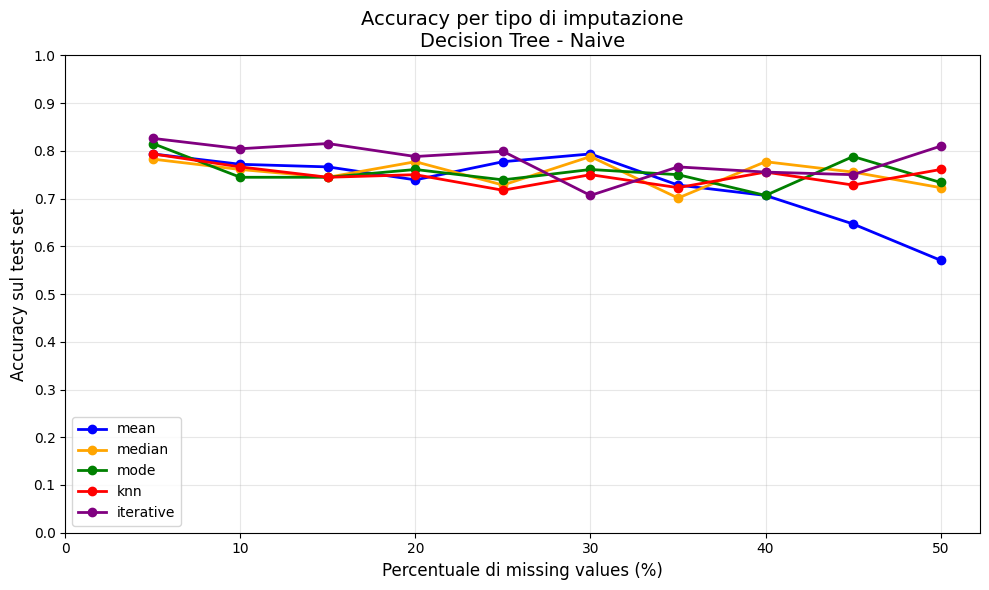

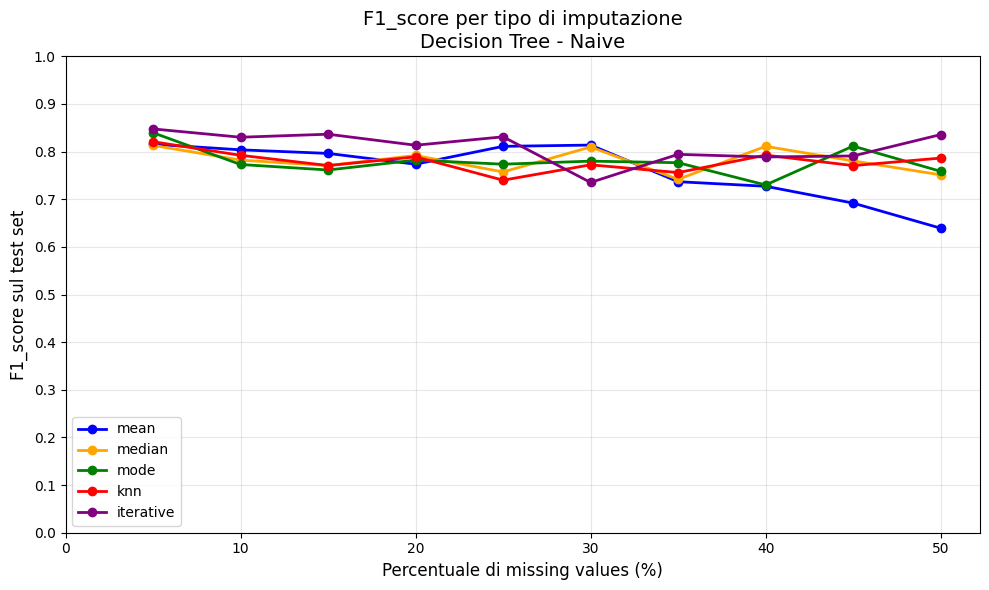

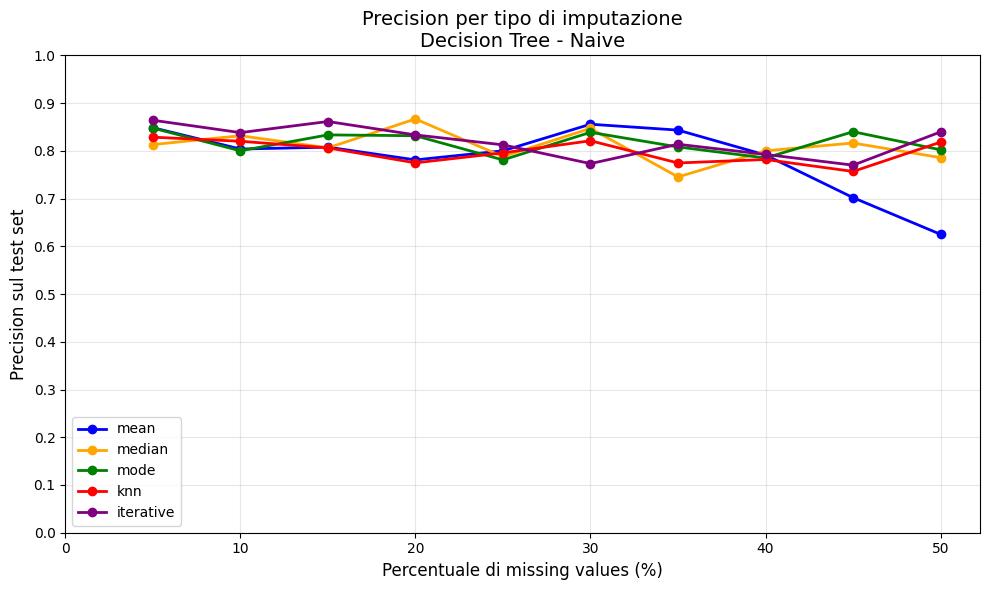

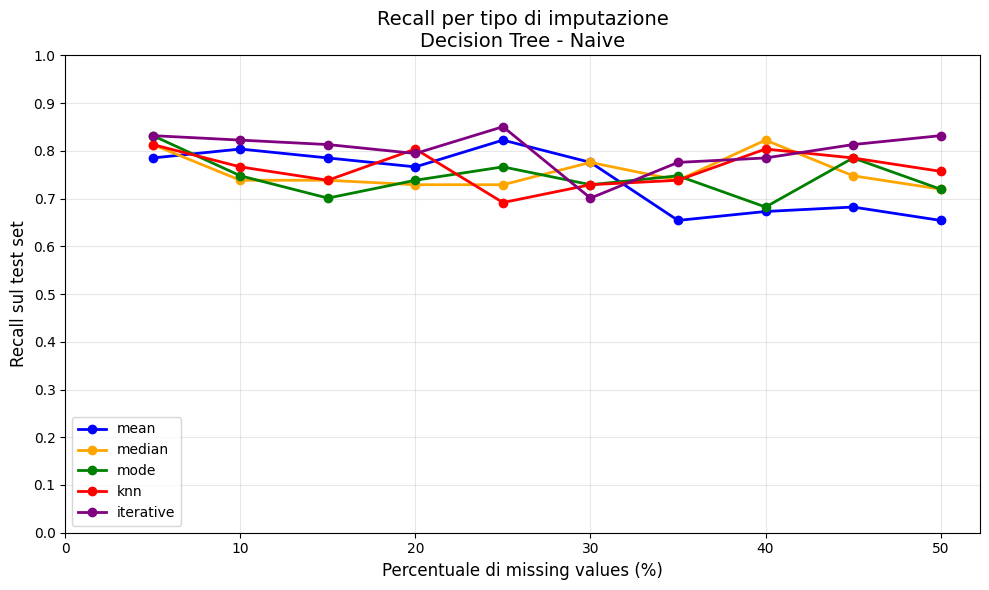

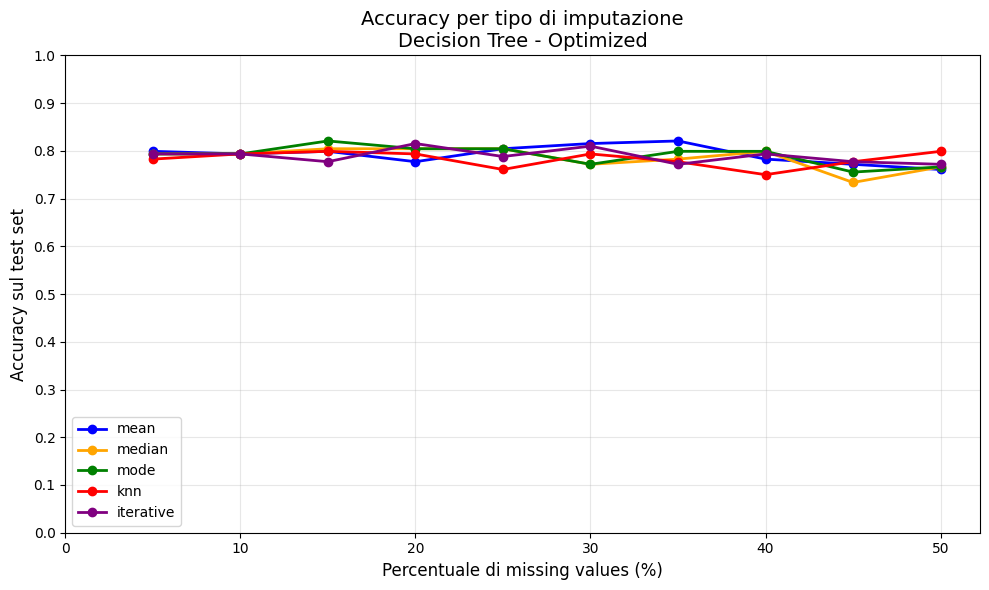

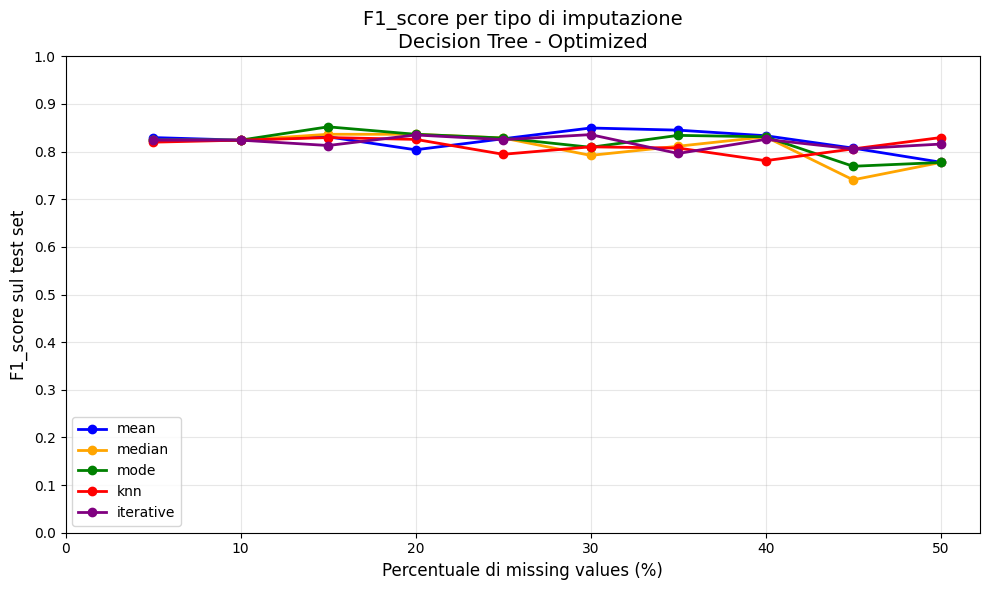

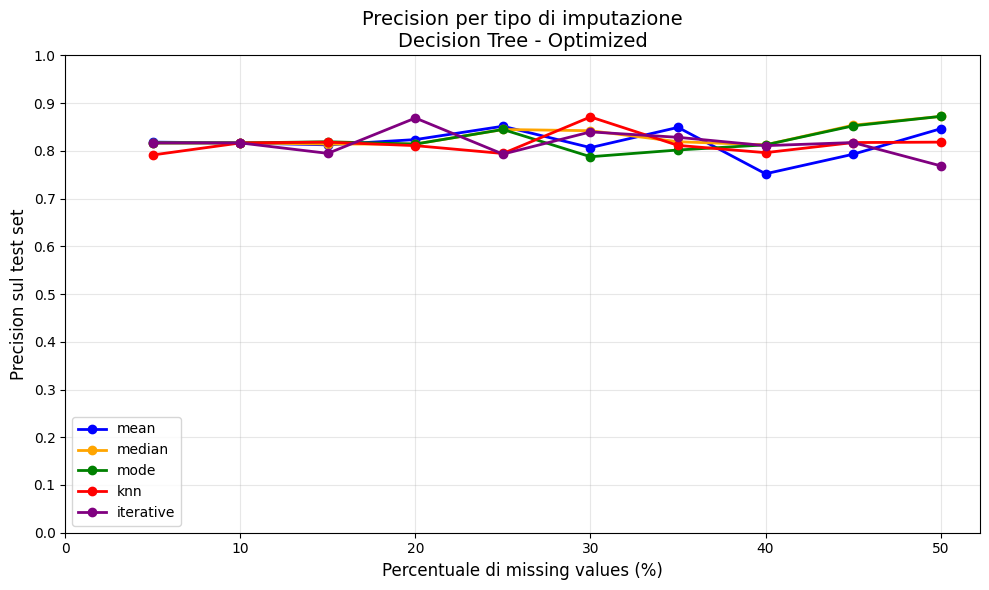

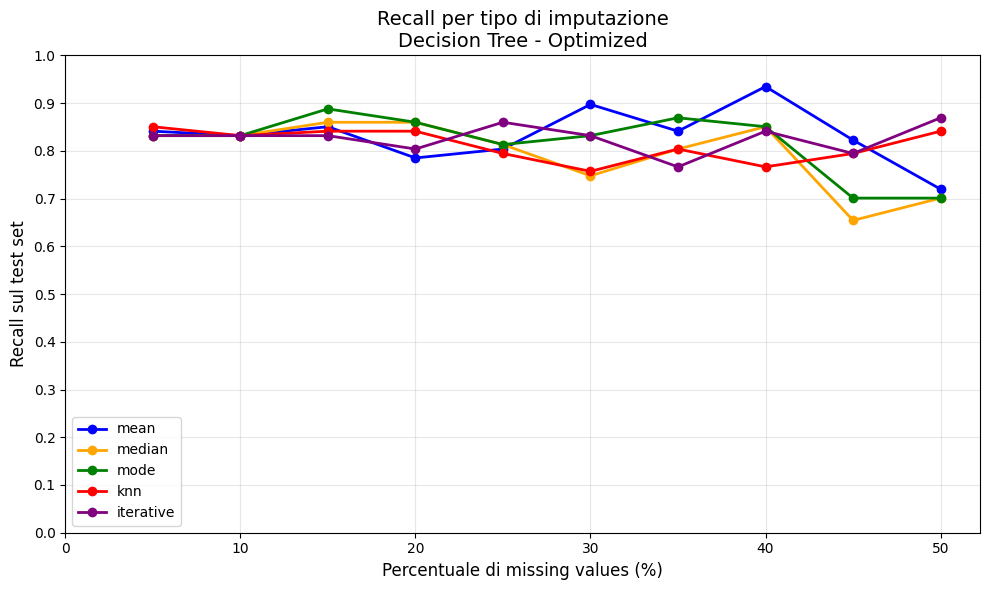

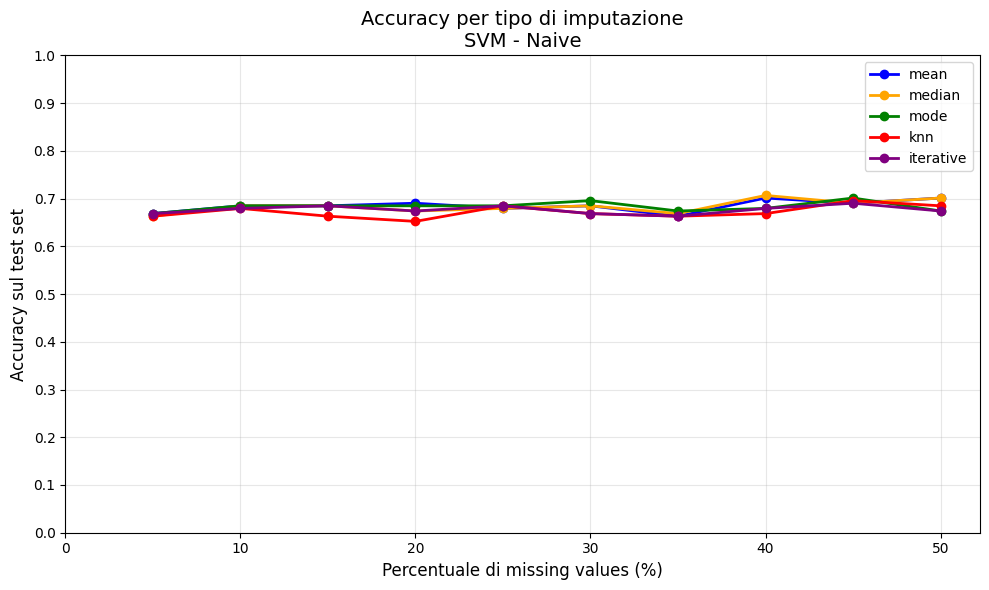

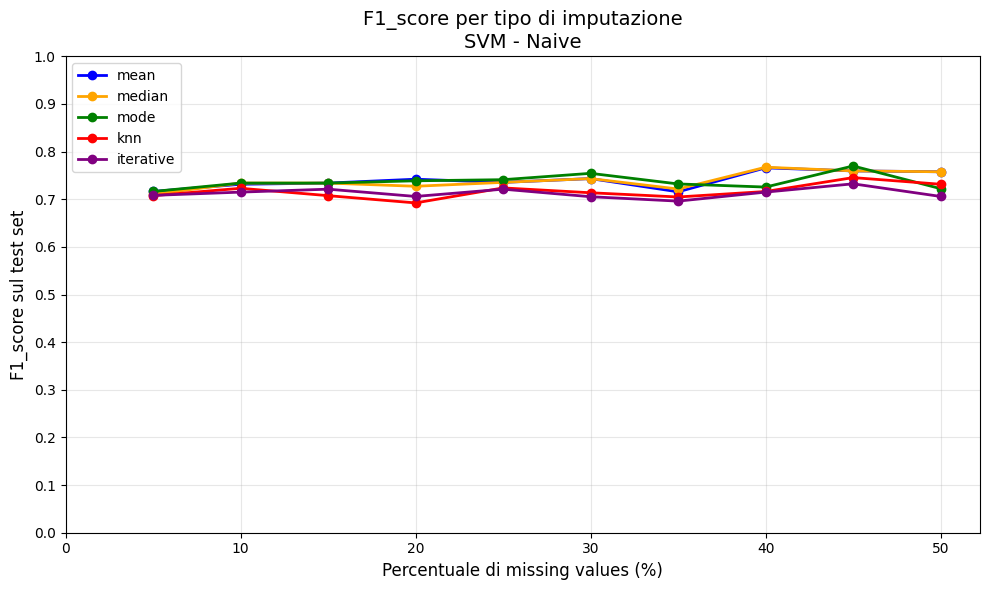

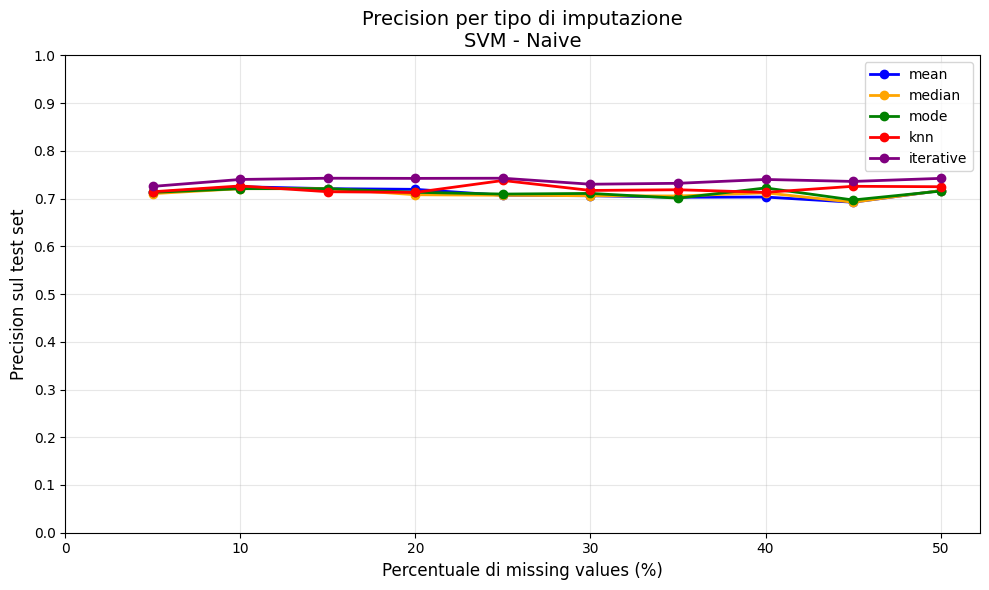

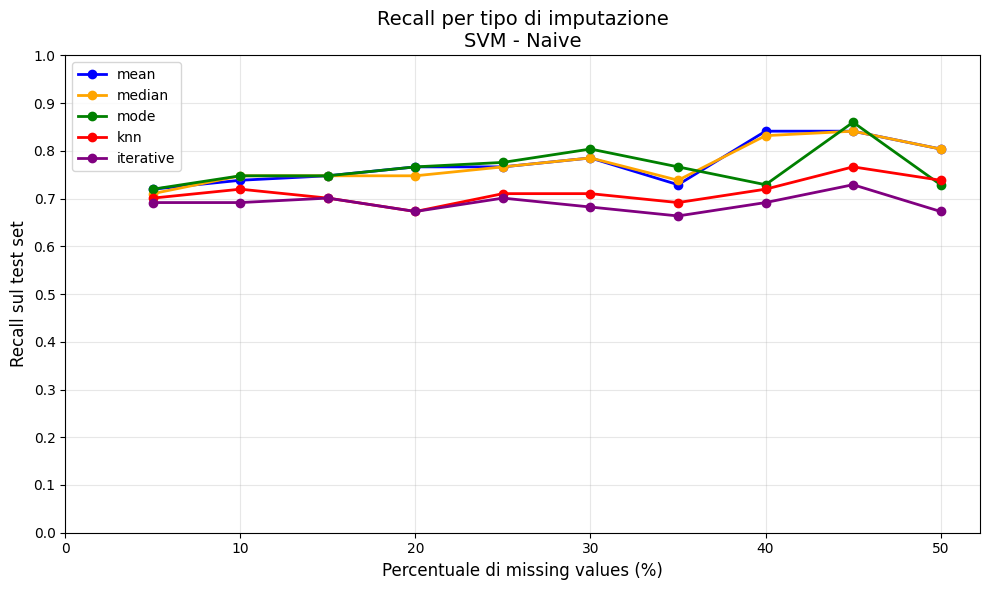

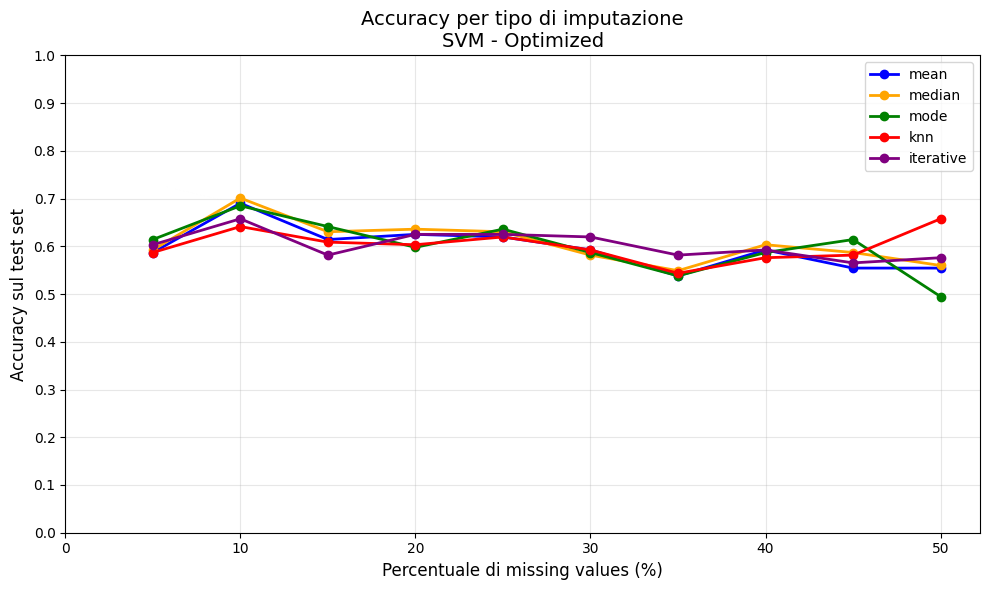

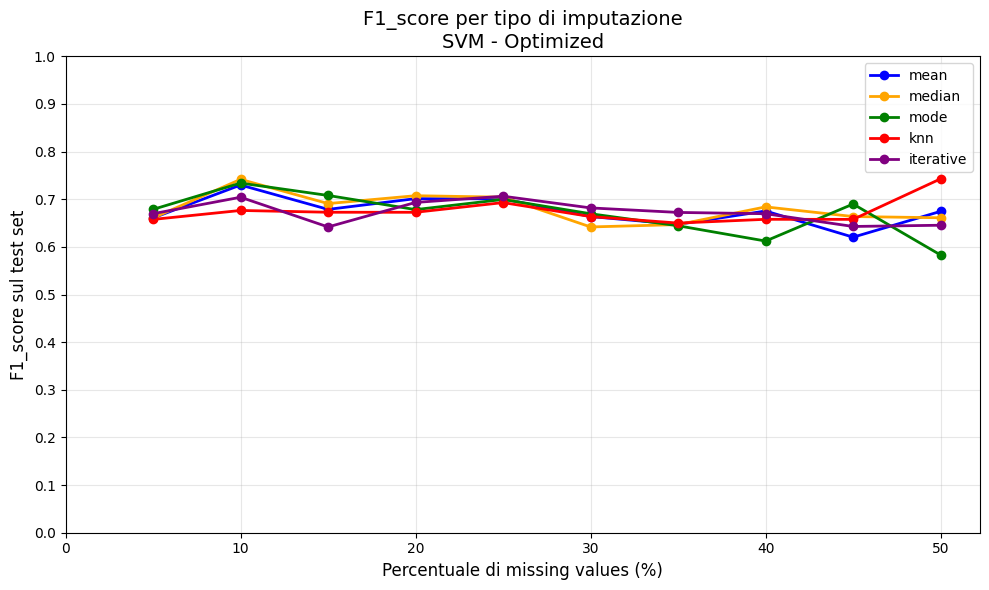

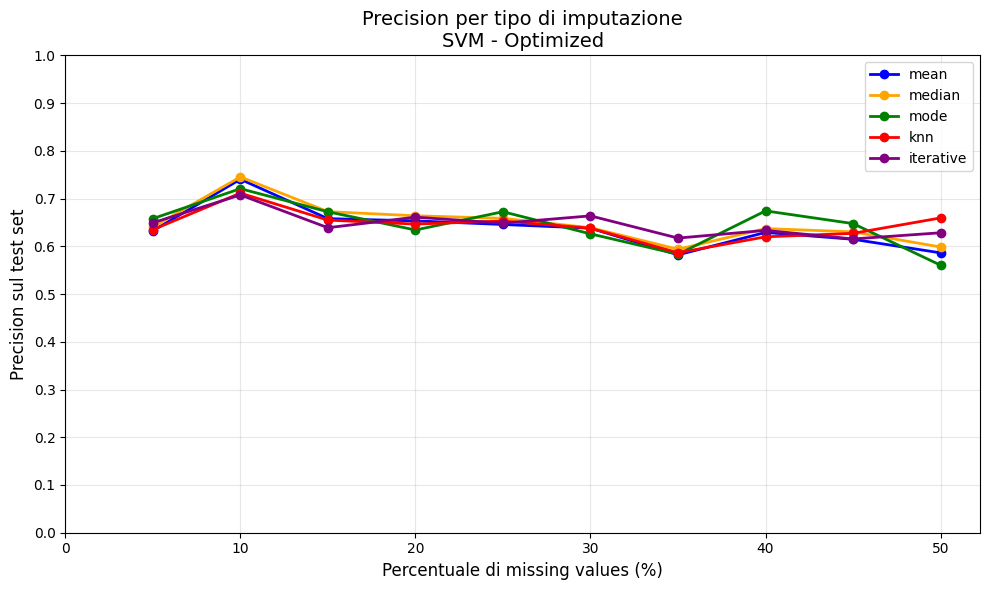

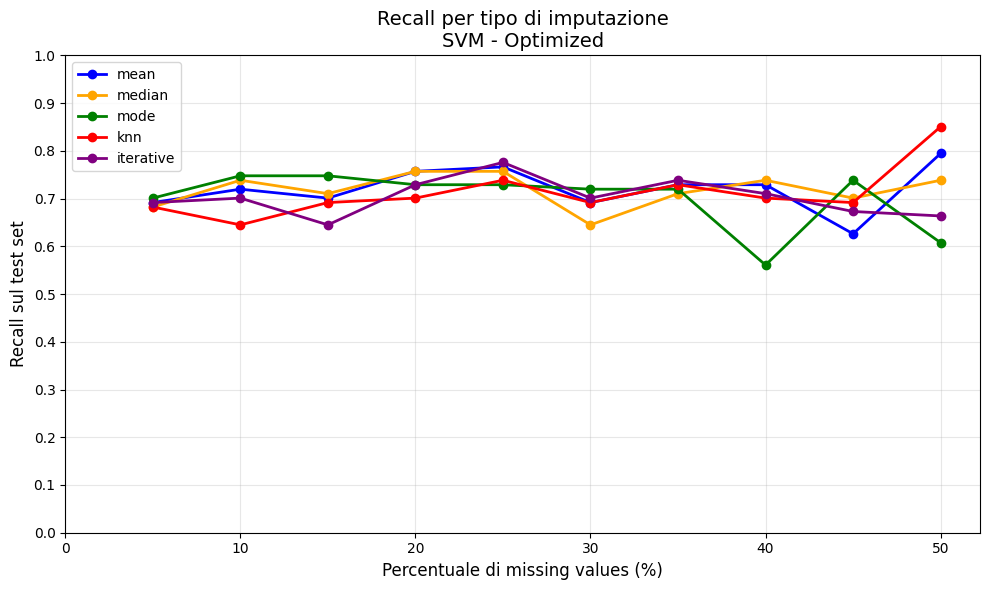

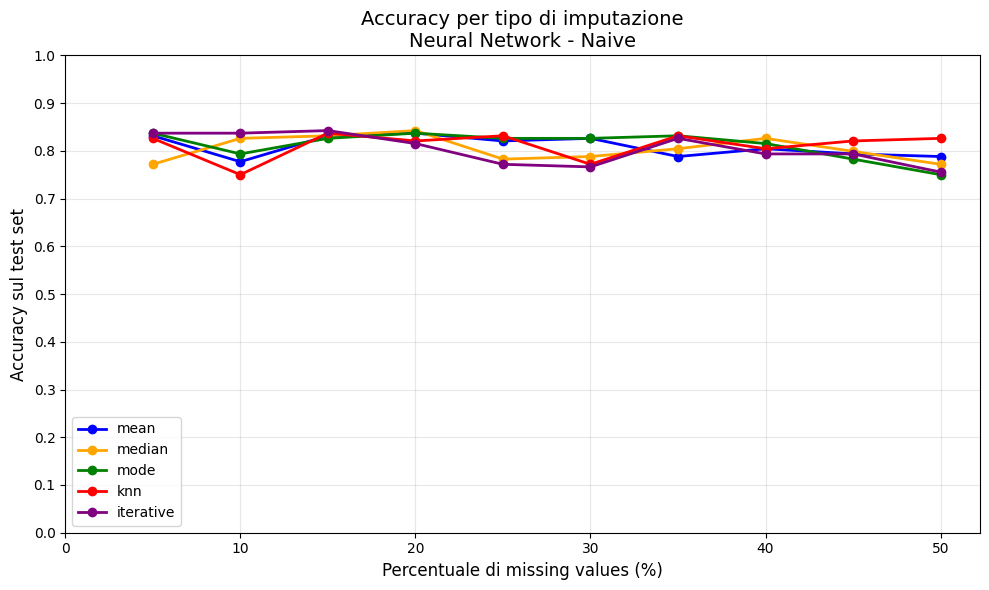

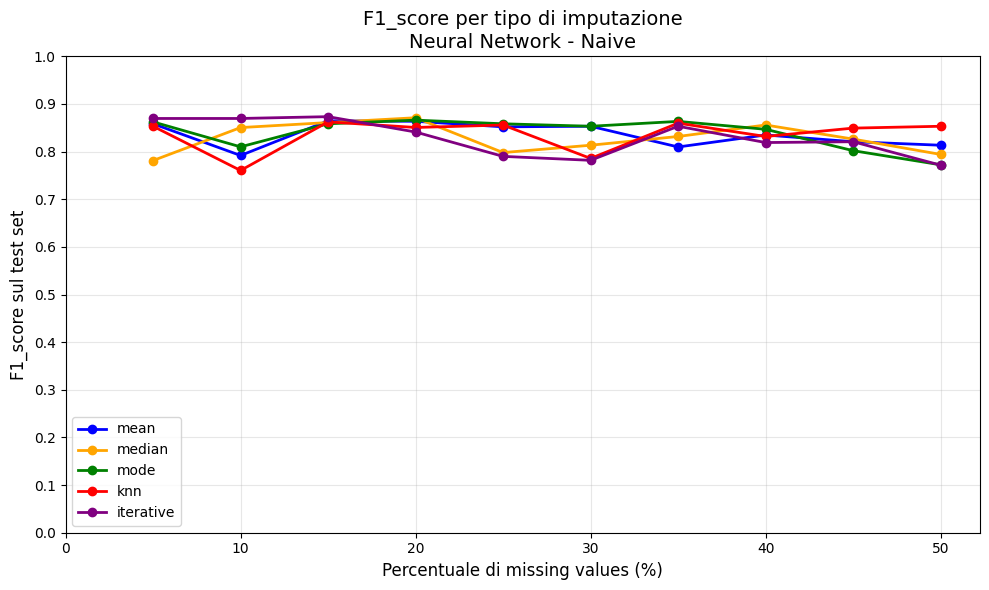

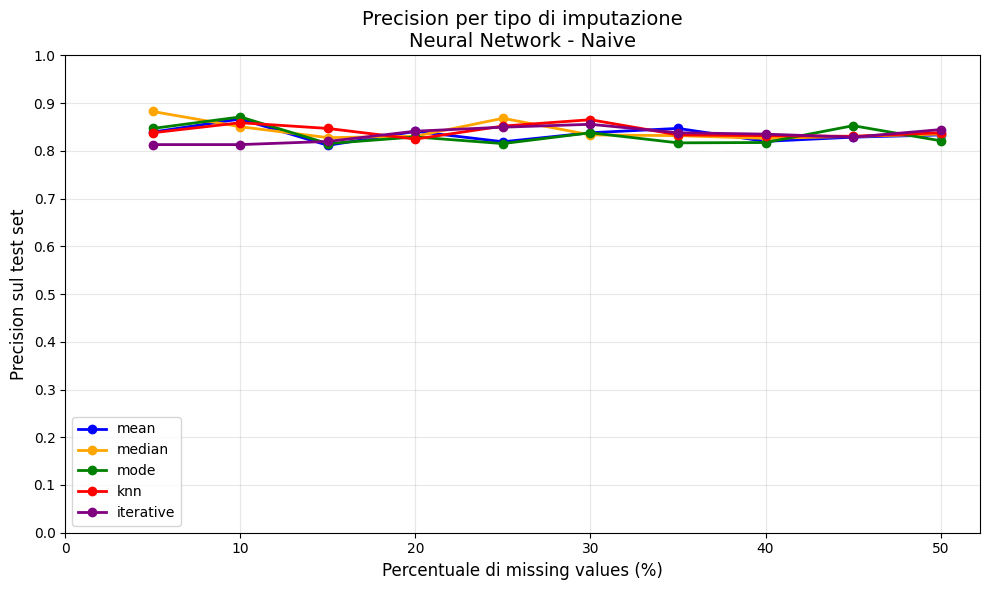

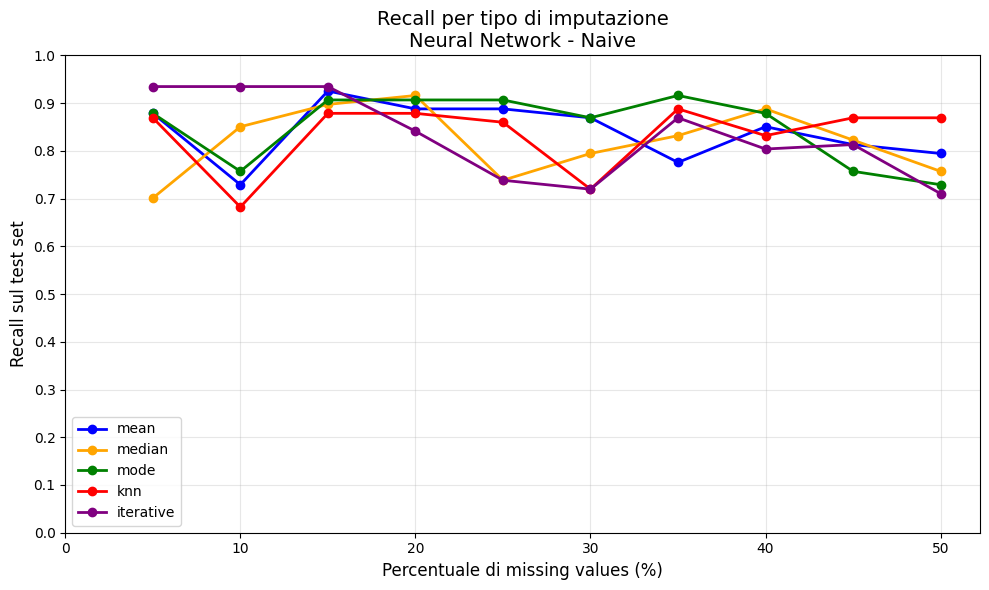

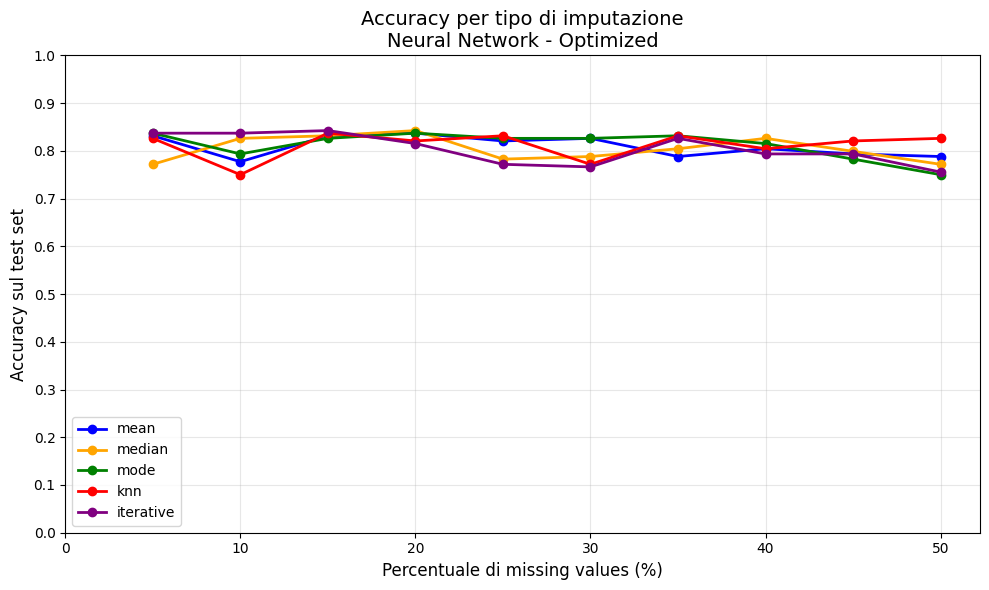

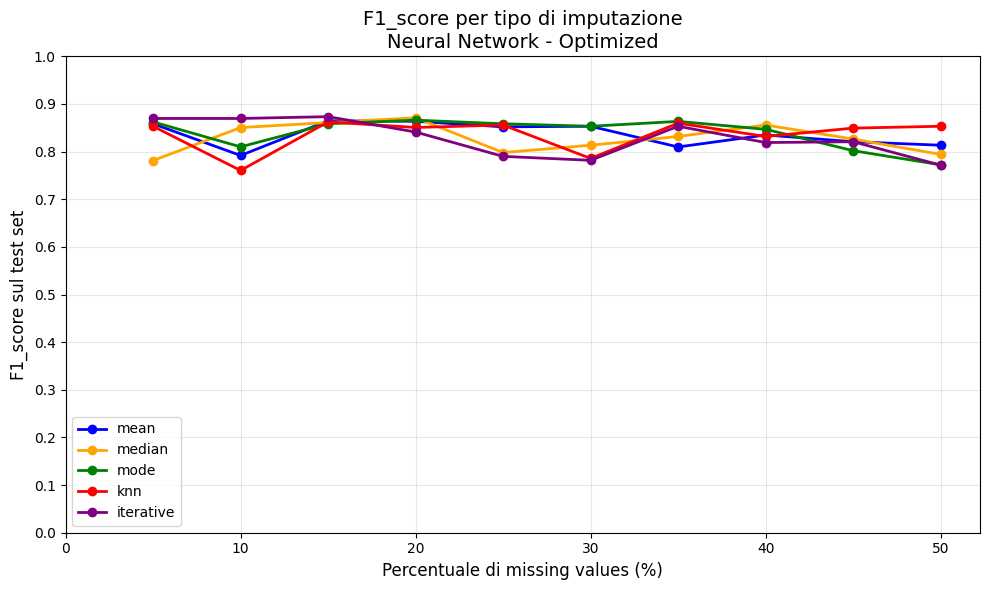

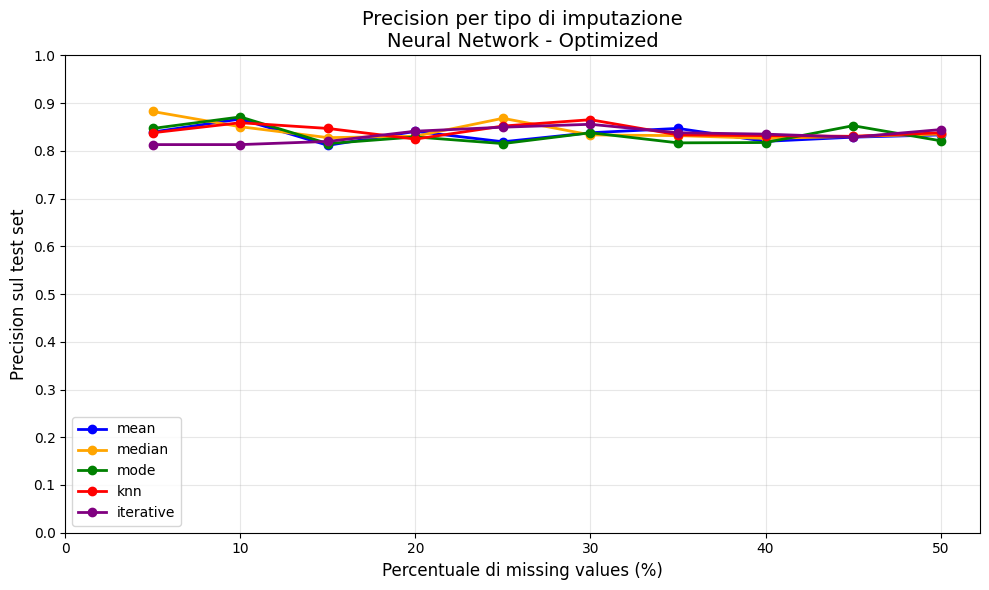

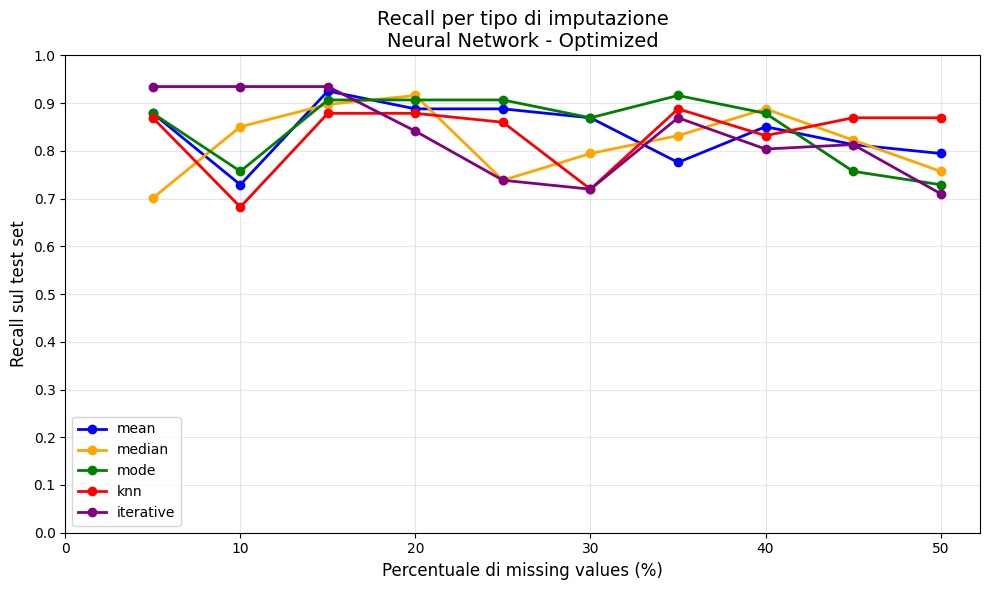

In [51]:
def plot_single_metric_by_imputation(all_metrics_outliers, degraded_datasets, model_name, approach='Optimized', figsize=(10, 6)):
    """
    Crea un grafico separato per ciascuna metrica vs percentuale di missing values,
    confrontando le strategie di imputazione per un modello e approccio specifico.
    """
    missing_rates = list(degraded_datasets.keys())
    metrics_df = pd.DataFrame(all_metrics_outliers)
    metrics_df['missing_rate'] = [missing_rates[s] for s in metrics_df['step']]
    imputations = metrics_df['imputation'].unique()
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    metric_names = ['accuracy', 'f1_score', 'precision', 'recall']

    for metric in metric_names:
        plt.figure(figsize=figsize)
        for i, imp in enumerate(imputations):
            filtered_df = metrics_df[
                (metrics_df["approach"] == approach) & 
                (metrics_df["model"] == model_name) & 
                (metrics_df["imputation"] == imp)
            ].sort_values("missing_rate")
            if filtered_df.empty:
                continue
            plt.plot(filtered_df["missing_rate"]*100, filtered_df[metric],
                     marker='o', color=colors[i % len(colors)], linewidth=2, markersize=6, label=f"{imp}")

        plt.xlabel("Percentuale di missing values (%)", fontsize=12)
        plt.ylabel(f"{metric.capitalize()} sul test set", fontsize=12)
        plt.title(f"{metric.capitalize()} per tipo di imputazione\n{model_name} - {approach}", fontsize=14)
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.xticks(np.arange(0, max(missing_rates)*100 + 10, 10))
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

# Esempio di chiamata per ogni modello/approccio
plot_single_metric_by_imputation(all_metrics_outliers, degraded_datasets, 'Decision Tree', approach='Naive')
plot_single_metric_by_imputation(all_metrics_outliers, degraded_datasets, 'Decision Tree', approach='Optimized')
plot_single_metric_by_imputation(all_metrics_outliers, degraded_datasets, 'SVM', approach='Naive')
plot_single_metric_by_imputation(all_metrics_outliers, degraded_datasets, 'SVM', approach='Optimized')
plot_single_metric_by_imputation(all_metrics_outliers, degraded_datasets, 'Neural Network', approach='Naive')
plot_single_metric_by_imputation(all_metrics_outliers, degraded_datasets, 'Neural Network', approach='Optimized')

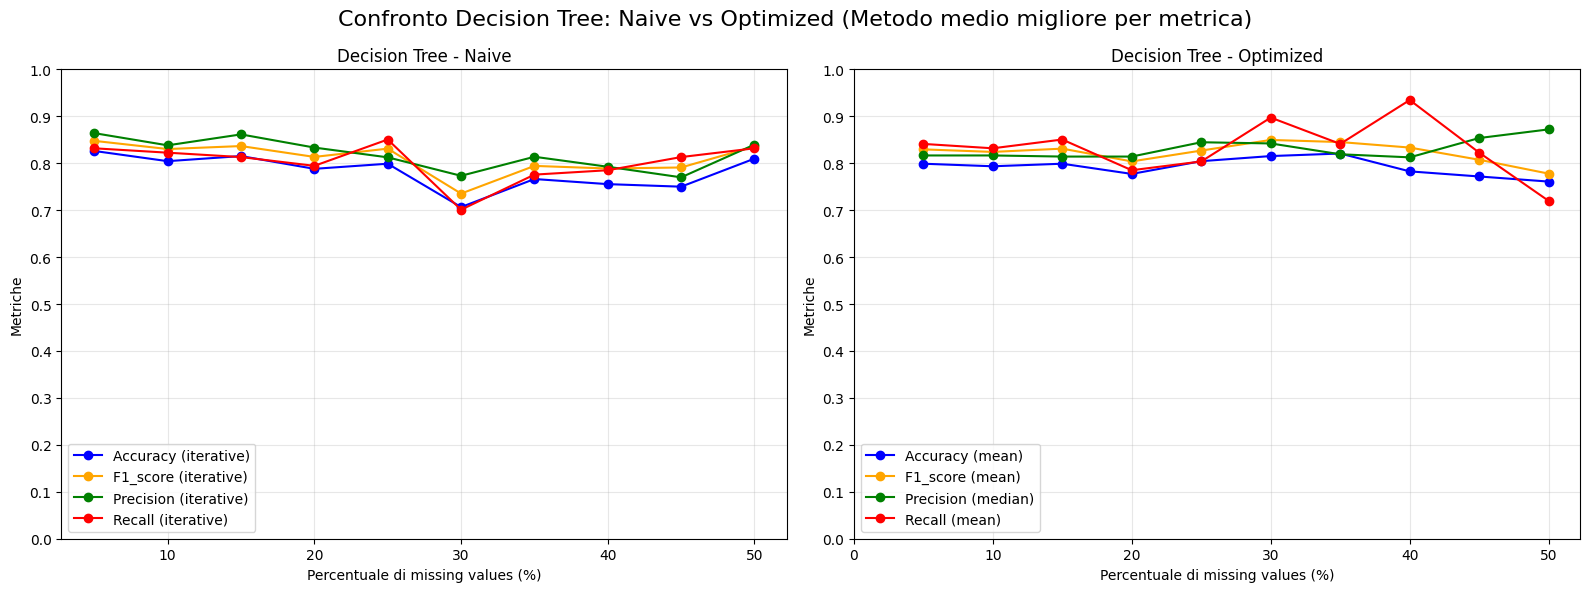

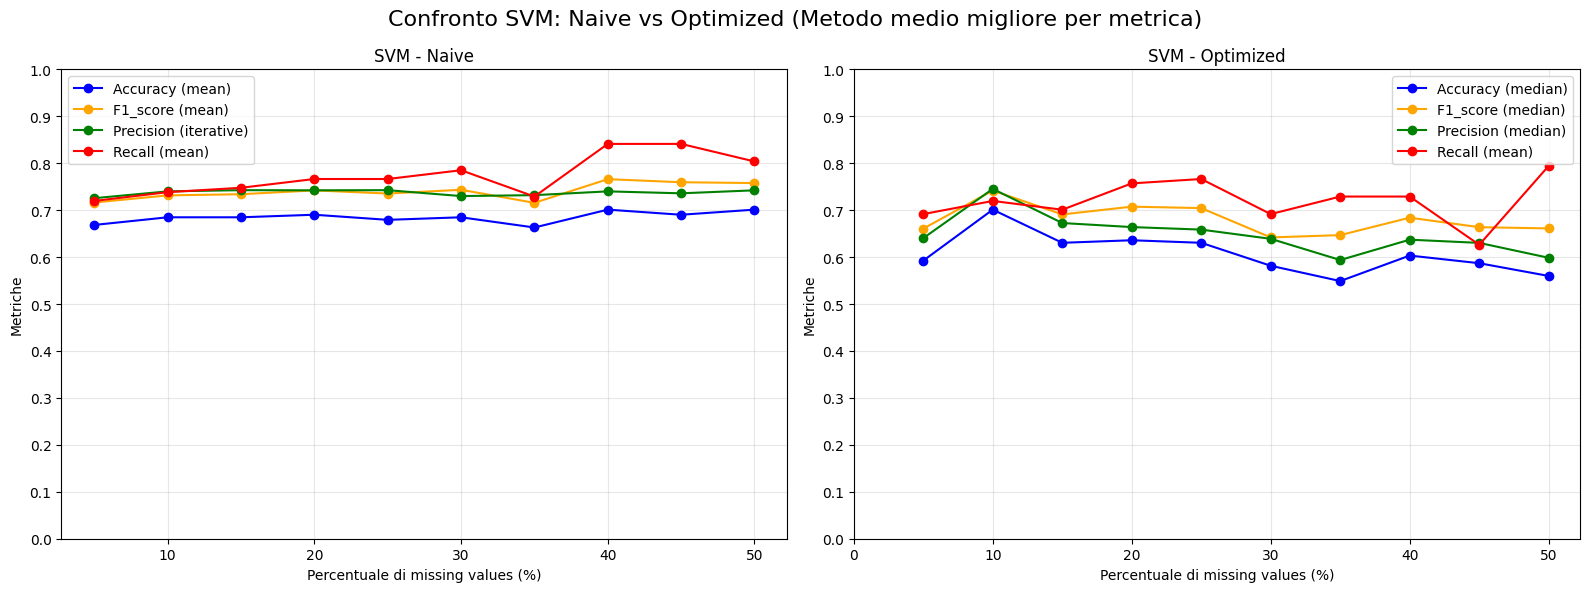

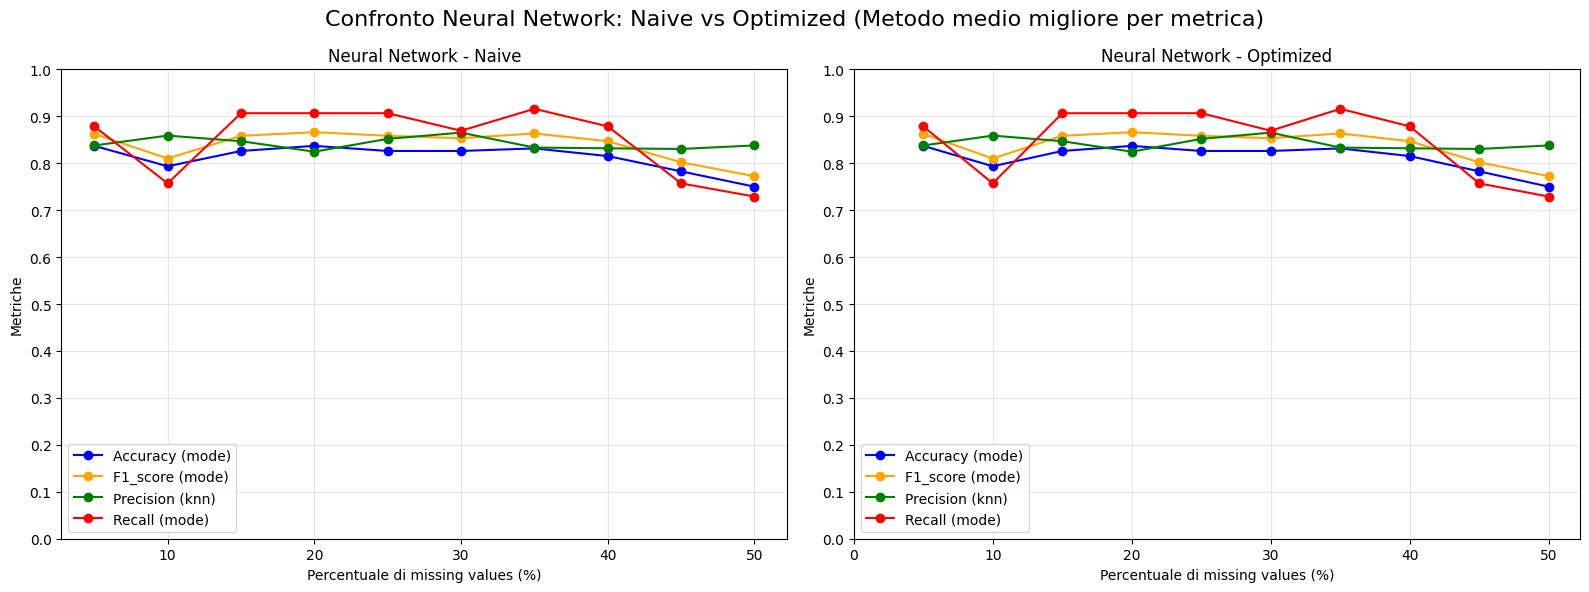

In [52]:
def plot_naive_vs_optimized_best_avg_imputation(all_metrics_outliers, degraded_datasets, model_name, figsize=(16, 6)):
    """
    Confronta Naive vs Optimized per un modello, mostrando per ogni metrica
    solo il metodo di imputazione che ha ottenuto la media migliore.
    """
    missing_rates = list(degraded_datasets.keys())
    metrics_df = pd.DataFrame(all_metrics_outliers)
    metrics_df['missing_rate'] = [missing_rates[s] for s in metrics_df['step']]
    metric_names = ['accuracy', 'f1_score', 'precision', 'recall']
    colors = {'accuracy': 'blue', 'f1_score': 'orange', 'precision': 'green', 'recall': 'red'}

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    for i, approach in enumerate(['Naive', 'Optimized']):
        approach_df = metrics_df[
            (metrics_df["approach"] == approach) & 
            (metrics_df["model"] == model_name)
        ]
        for metric in metric_names:
            # Calcola la media per ogni metodo di imputazione
            avg_by_imp = approach_df.groupby('imputation')[metric].mean()
            best_imp = avg_by_imp.idxmax()
            best_df = approach_df[approach_df['imputation'] == best_imp].sort_values('missing_rate')
            axes[i].plot(best_df['missing_rate']*100, best_df[metric], marker='o', color=colors[metric],
                         label=f"{metric.capitalize()} ({best_imp})")
        axes[i].set_xlabel("Percentuale di missing values (%)")
        axes[i].set_ylabel("Metriche")
        axes[i].set_title(f"{model_name} - {approach}")
        axes[i].set_yticks(np.arange(0, 1.1, 0.1))
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    plt.suptitle(f"Confronto {model_name}: Naive vs Optimized (Metodo medio migliore per metrica)", fontsize=16)
    plt.xticks(np.arange(0,51,10))
    plt.tight_layout()
    plt.show()

# Esempio di chiamata
plot_naive_vs_optimized_best_avg_imputation(all_metrics_outliers, degraded_datasets, 'Decision Tree')
plot_naive_vs_optimized_best_avg_imputation(all_metrics_outliers, degraded_datasets, 'SVM')
plot_naive_vs_optimized_best_avg_imputation(all_metrics_outliers, degraded_datasets, 'Neural Network')

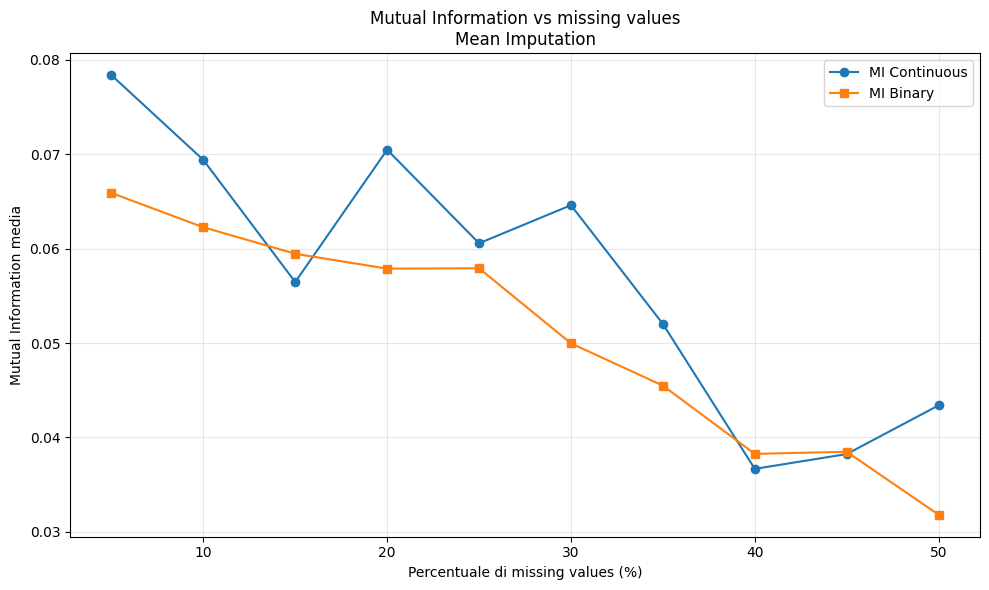

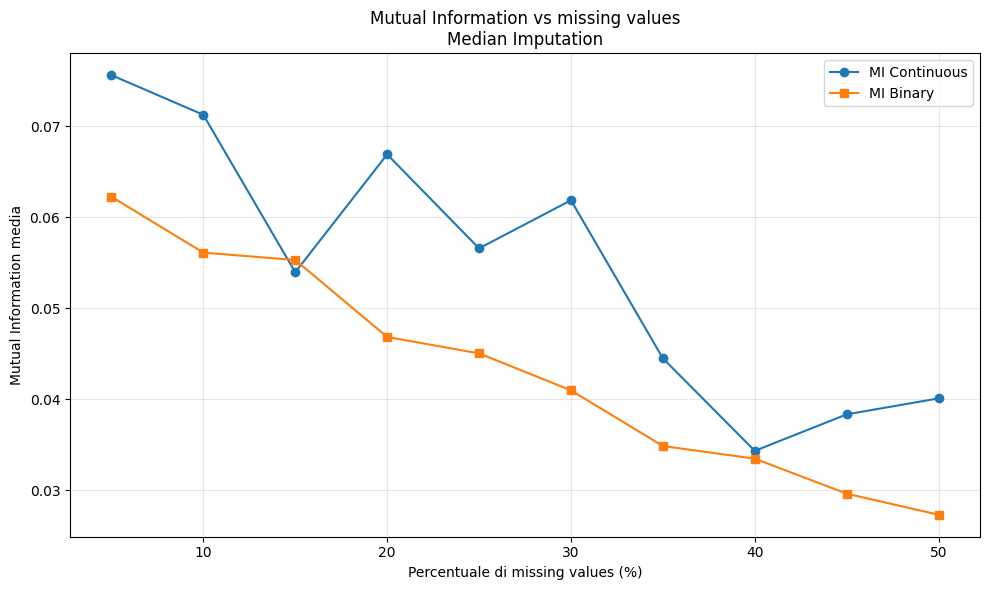

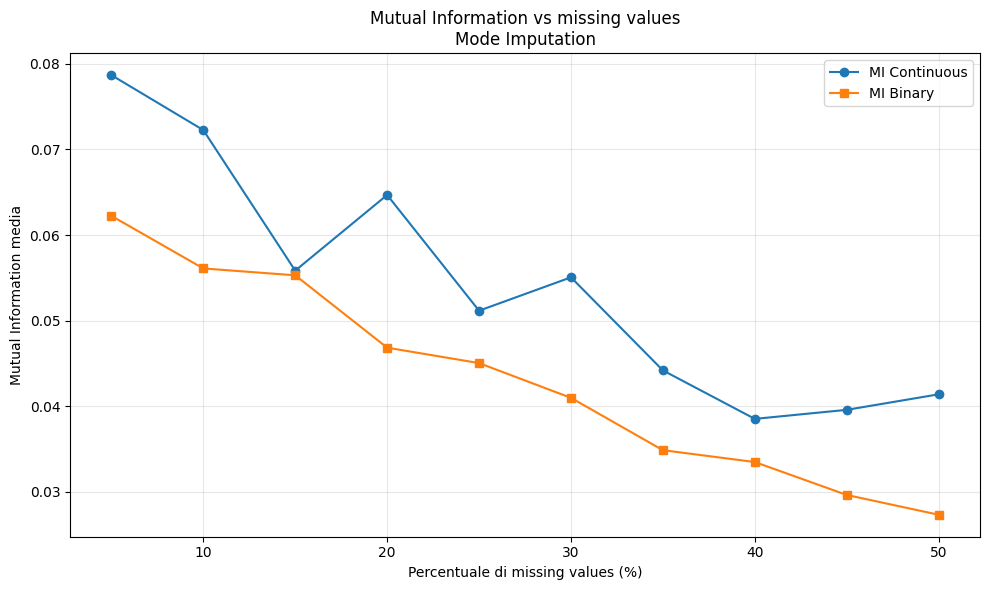

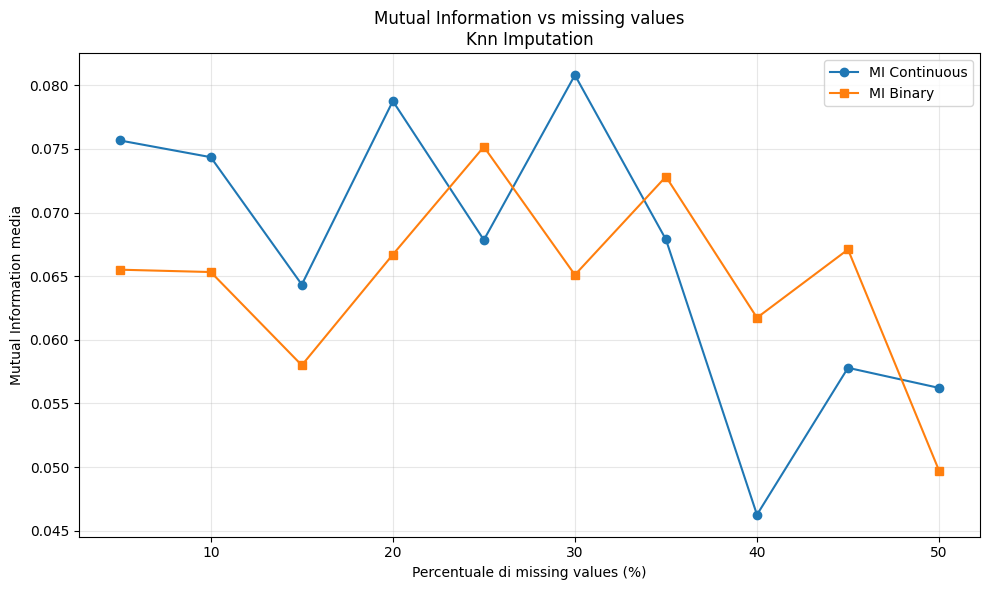

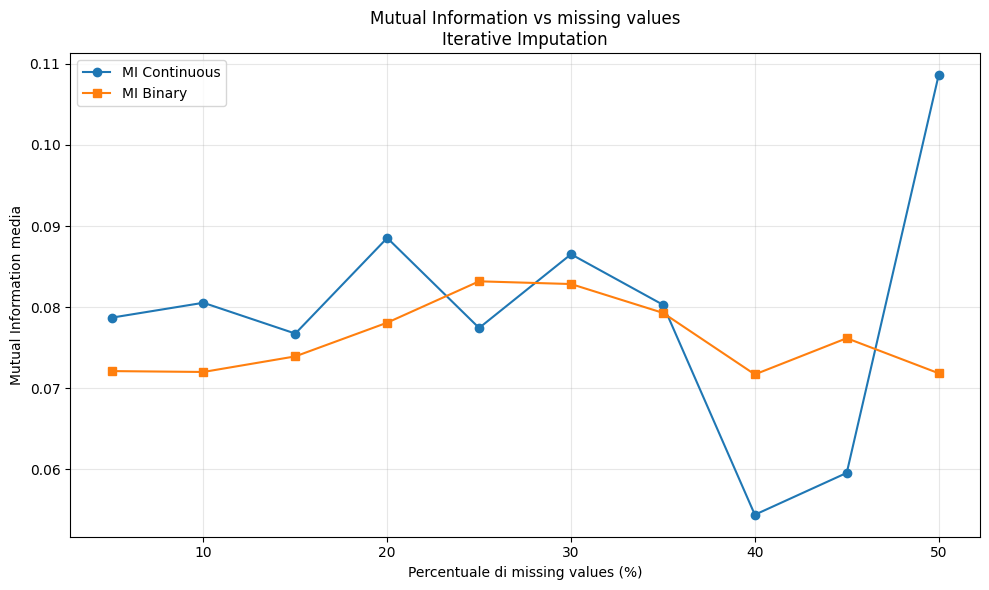

In [53]:
df_results = pd.DataFrame(mutua_informazione_feature)
imputation_methods = df_results["imputation"].unique()

for imp in imputation_methods:
    filtered = df_results[df_results["imputation"] == imp]
    # Raggruppa per percentuale di missing e calcola la media
    grouped = filtered.groupby("perc_missing")[["MI_numerical", "MI_binary"]].mean().reset_index()
    if grouped.empty:
        continue
    plt.figure(figsize=(10, 6))
    plt.plot(grouped["perc_missing"]*100, grouped["MI_numerical"], marker='o', label="MI Continuous")
    plt.plot(grouped["perc_missing"]*100, grouped["MI_binary"], marker='s', label="MI Binary")
    plt.xlabel("Percentuale di missing values (%)")
    plt.ylabel("Mutual Information media")
    plt.title(f"Mutual Information vs missing values\n{imp.capitalize()} Imputation")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [54]:
print(pd.DataFrame(mutua_informazione_feature).head())
print(pd.DataFrame(mutua_informazione_feature).columns)

   MI_numerical  MI_binary  perc_missing          model approach imputation  \
0      0.078351   0.065882          0.05  Decision Tree    Naive       mean   
1      0.069376   0.062250          0.10  Decision Tree    Naive       mean   
2      0.056453   0.059442          0.15  Decision Tree    Naive       mean   
3      0.070454   0.057870          0.20  Decision Tree    Naive       mean   
4      0.060555   0.057908          0.25  Decision Tree    Naive       mean   

   step  
0     0  
1     1  
2     2  
3     3  
4     4  
Index(['MI_numerical', 'MI_binary', 'perc_missing', 'model', 'approach',
       'imputation', 'step'],
      dtype='object')


🔍 AVVIO ANALISI COMPREHENSIVE DEL PROGETTO

4️⃣ Analizzando curve ROC e calibrazione...
=== ANALISI ROC E CALIBRAZIONE ===



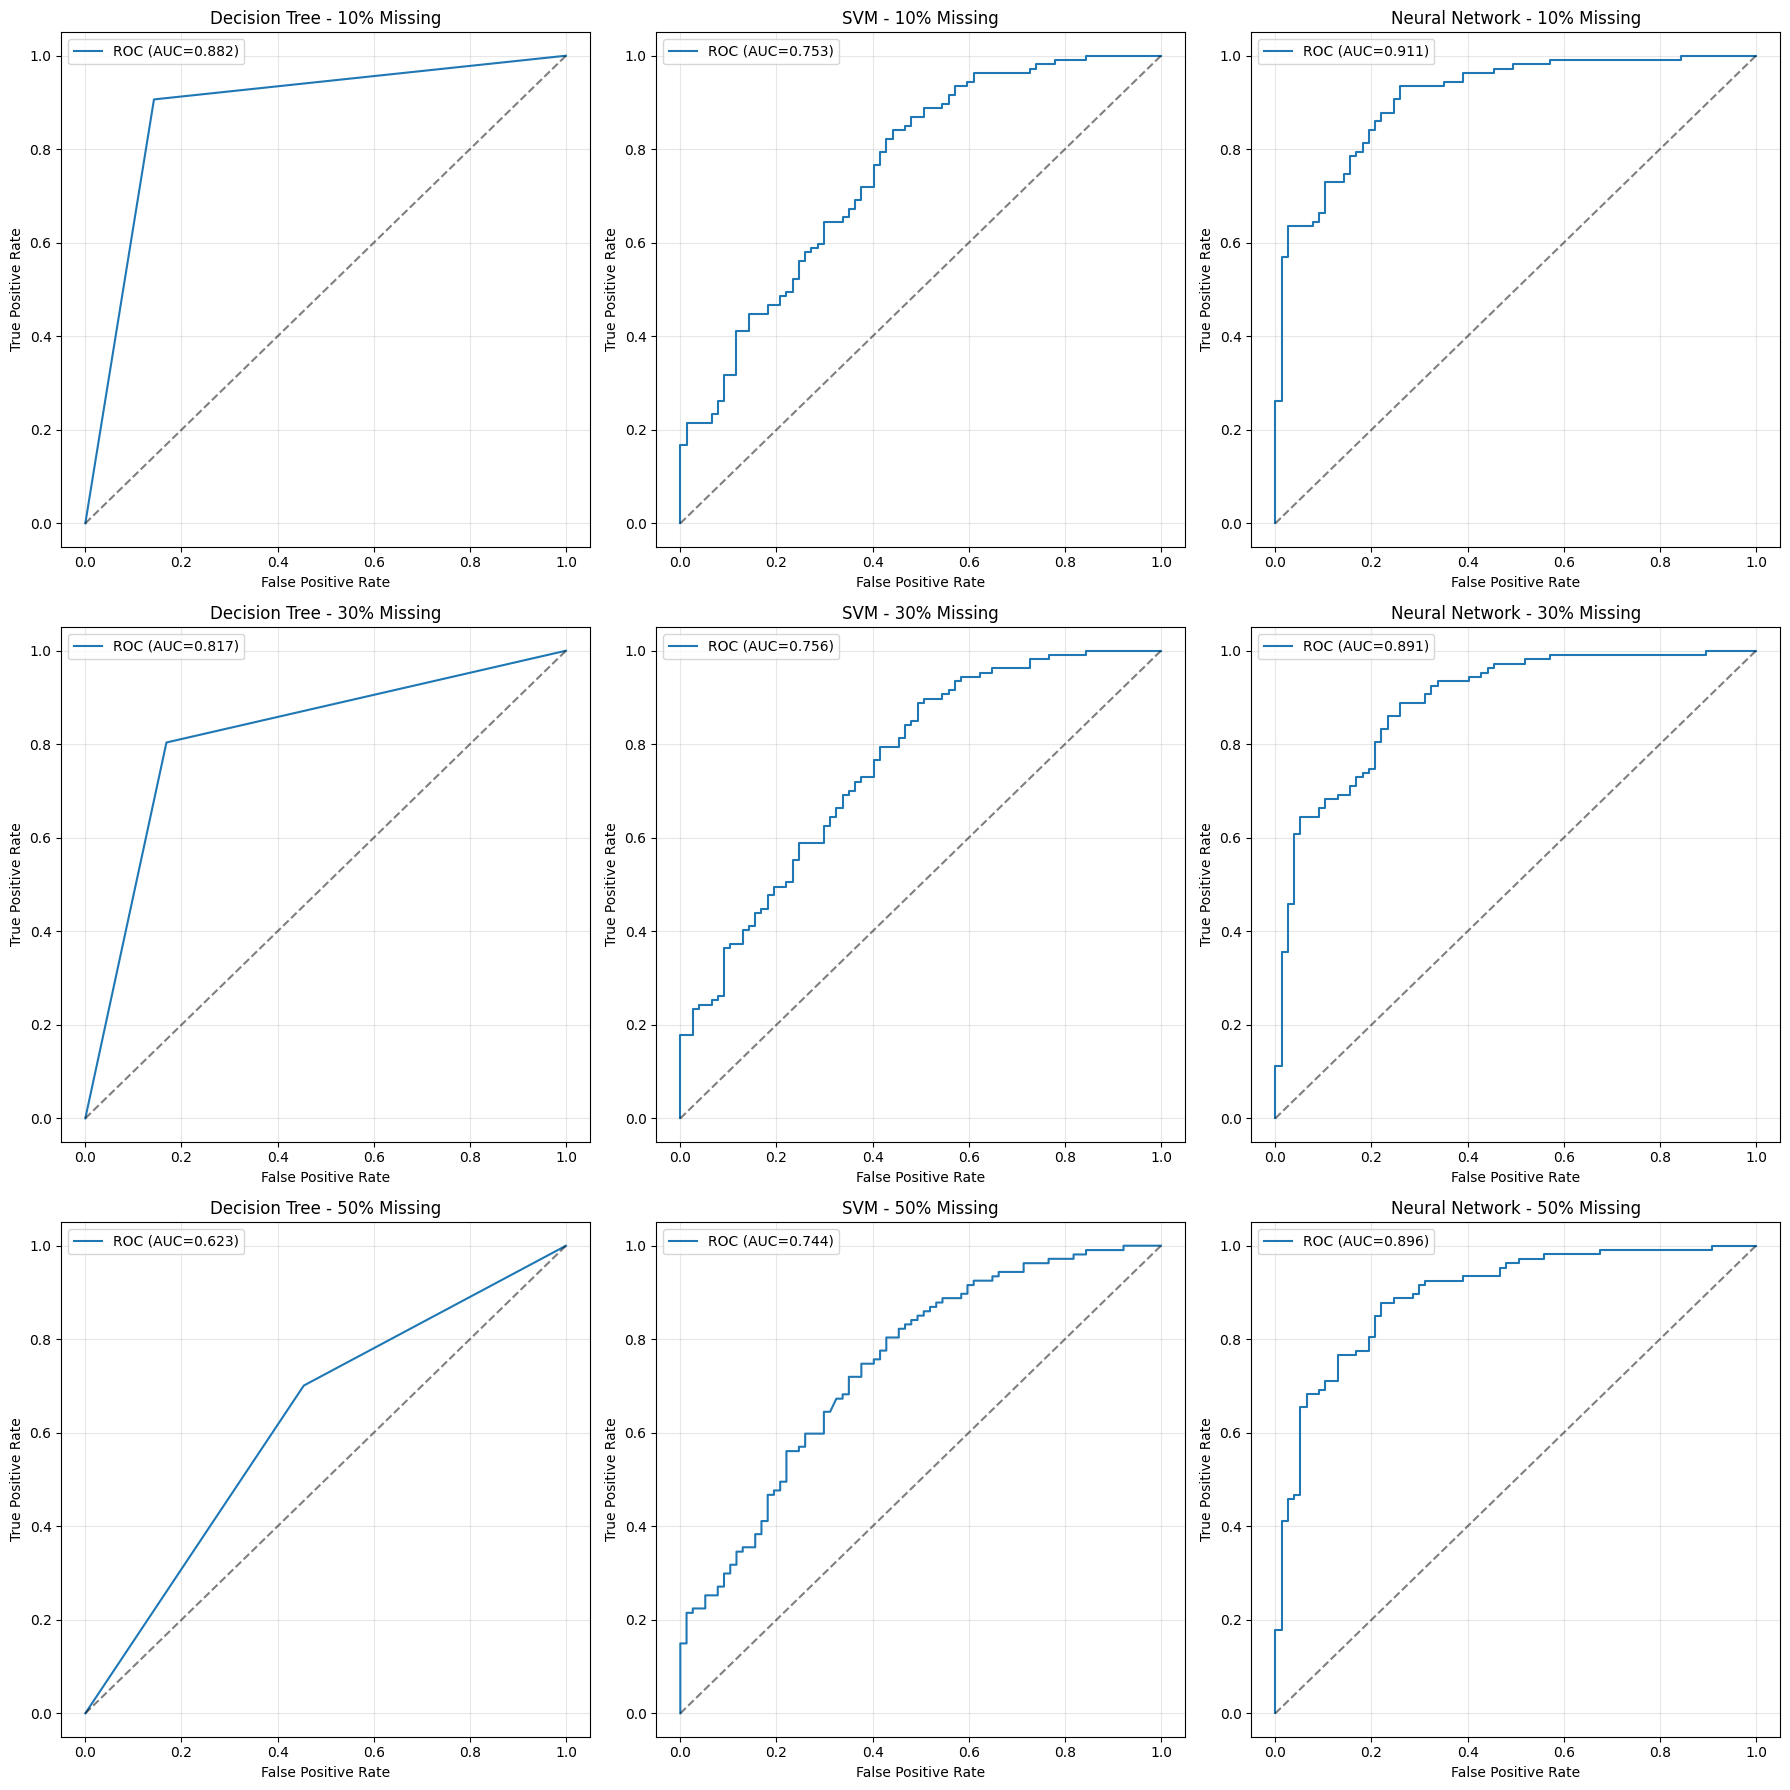


5️⃣ Analizzando impatto delle feature...
=== ANALISI DELL'IMPATTO DELLE FEATURE ===



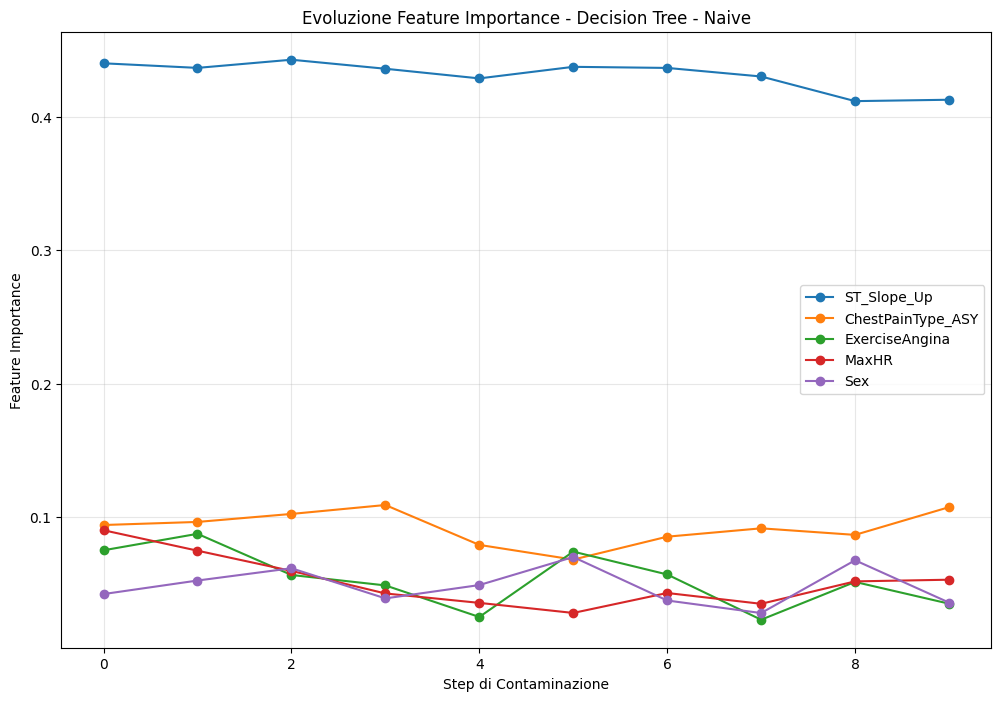


Decision Tree - Naive:
Media importanza feature continue: 0.0409
Media importanza feature binarie: 0.0612


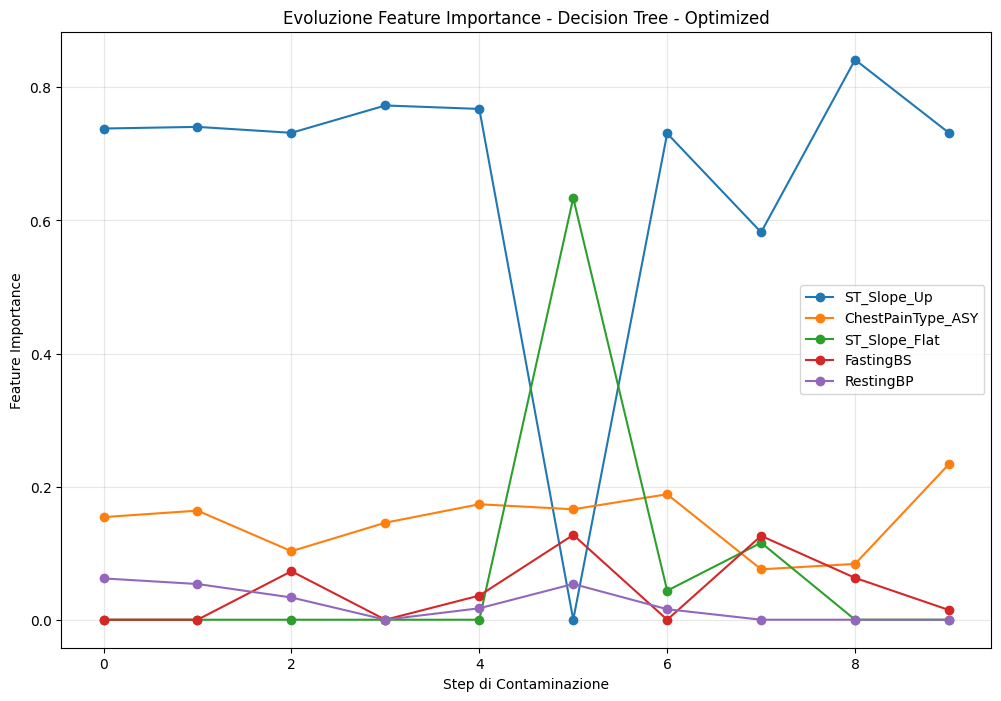


Decision Tree - Optimized:
Media importanza feature continue: 0.0082
Media importanza feature binarie: 0.0738

✅ ANALISI COMPREHENSIVE COMPLETATA!


In [ ]:
# %%
# ANALISI AGGIUNTIVE PER IL PROGETTO MISSING VALUES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')


# %%
# 4. ANALISI ROC E CALIBRAZIONE
def roc_calibration_analysis(all_metrics_outliers, degraded_datasets, X_test_clean, y_test_clean):
    """
    Analisi delle curve ROC e della calibrazione dei modelli
    """
    print("=== ANALISI ROC E CALIBRAZIONE ===\n")
    
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.svm import SVC
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.impute import SimpleImputer
    from sklearn.calibration import CalibratedClassifierCV
    
    # Testa su alcuni step rappresentativi
    test_steps = [0.1, 0.3, 0.5]
    models_config = {
        'Decision Tree': DecisionTreeClassifier(),
        'SVM': SVC(probability=True),
        'Neural Network': MLPClassifier(max_iter=1000)
    }
    
    fig, axes = plt.subplots(len(test_steps), 3, figsize=(18, 6*len(test_steps)))
    if len(test_steps) == 1:
        axes = axes.reshape(1, -1)
    
    roc_results = []
    
    for step_idx, perc in enumerate(test_steps):
        if perc not in degraded_datasets:
            continue
            
        df_degraded = degraded_datasets[perc]
        X_contaminated = df_degraded.drop('HeartDisease', axis=1)
        y_contaminated = df_degraded['HeartDisease']
        
        X_train, _, y_train, _ = train_test_split(
            X_contaminated, y_contaminated, test_size=0.2, random_state=42
        )
        
        imputer = SimpleImputer(strategy='mean')
        X_train_imp = imputer.fit_transform(X_train)
        X_test_imp = imputer.transform(X_test_clean)
        
        for model_idx, (model_name, model) in enumerate(models_config.items()):
            model.fit(X_train_imp, y_train)
            
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test_imp)[:, 1]
            else:
                y_proba = model.decision_function(X_test_imp)
            
            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test_clean, y_proba)
            auc_score = roc_auc_score(y_test_clean, y_proba)
            
            axes[step_idx, model_idx].plot(fpr, tpr, label=f'ROC (AUC={auc_score:.3f})')
            axes[step_idx, model_idx].plot([0, 1], [0, 1], 'k--', alpha=0.5)
            axes[step_idx, model_idx].set_xlabel('False Positive Rate')
            axes[step_idx, model_idx].set_ylabel('True Positive Rate')
            axes[step_idx, model_idx].set_title(f'{model_name} - {int(perc*100)}% Missing')
            axes[step_idx, model_idx].legend()
            axes[step_idx, model_idx].grid(True, alpha=0.3)
            
            roc_results.append({
                'model': model_name,
                'missing_perc': perc,
                'auc_score': auc_score
            })
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(roc_results)

# %%
# 5. ANALISI DELL'IMPATTO SPECIFICO DELLE FEATURE
def feature_impact_analysis(feature_importances, continuous_features, binary_features):
    """
    Analizza come l'importanza delle feature cambia con l'aumento dei missing values
    """

    # Rimuovi la target dalle liste se presente
    continuous_features = [f for f in continuous_features if f != 'HeartDisease']
    binary_features = [f for f in binary_features if f != 'HeartDisease']

    print("=== ANALISI DELL'IMPATTO DELLE FEATURE ===\n")
    
    if not feature_importances:
        print("Nessuna feature importance disponibile")
        return
    
    # Solo per Decision Tree che ha feature_importances
    for model_approach, step_importances in feature_importances.items():
        if 'Decision Tree' not in model_approach:
            continue
            
        # Crea DataFrame delle importanze per step
        importance_data = []
        for step, importances in step_importances.items():
            # Verifica che importances sia un array/lista valida
            if importances is not None and len(importances) > 0:
                for feat_idx, importance in enumerate(importances):
                    importance_data.append({
                        'step': step,
                        'feature_idx': feat_idx,
                        'importance': importance
                    })
        
        if not importance_data:
            continue
            
        importance_df = pd.DataFrame(importance_data)
        
        # Visualizza l'evoluzione delle top 5 feature più importanti
        plt.figure(figsize=(12, 8))
        
        # Trova le top feature basate sull'importanza media
        avg_importance = importance_df.groupby('feature_idx')['importance'].mean().sort_values(ascending=False)
        top_features = avg_importance.head(5).index
        
        for feat_idx in top_features:
            feat_data = importance_df[importance_df['feature_idx'] == feat_idx].sort_values('step')
            # Ottieni il nome della feature corrispondente all'indice
            if feat_idx < len(continuous_features):
                feat_name = continuous_features[feat_idx]
            elif feat_idx < len(continuous_features) + len(binary_features):
                feat_name = binary_features[feat_idx - len(continuous_features)]
            else:
                feat_name = f"Feature {feat_idx}"
            plt.plot(feat_data['step'], feat_data['importance'], 
                    marker='o', label=feat_name)
        
        plt.xlabel('Step di Contaminazione')
        plt.ylabel('Feature Importance')
        plt.title(f'Evoluzione Feature Importance - {model_approach}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Analisi separata per feature continue vs binarie (se hai i nomi delle feature)
        print(f"\n{model_approach}:")
        
        # Verifica che gli indici esistano prima di accedervi
        continuous_indices = [i for i in range(len(continuous_features)) if i in avg_importance.index]
        binary_start = len(continuous_features)
        binary_end = len(continuous_features) + len(binary_features)
        binary_indices = [i for i in range(binary_start, binary_end) if i in avg_importance.index]
        
        if continuous_indices:
            print(f"Media importanza feature continue: {avg_importance[continuous_indices].mean():.4f}")
        else:
            print("Nessuna feature continua trovata negli indici")
            
        if binary_indices:
            print(f"Media importanza feature binarie: {avg_importance[binary_indices].mean():.4f}")
        else:
            print("Nessuna feature binaria trovata negli indici")
    
# %%
# 8. FUNZIONE PRINCIPALE PER ESEGUIRE TUTTE LE ANALISI
def run_comprehensive_analysis(degraded_datasets, all_metrics_outliers, 
                              timing_collector_outliers, feature_importances,
                              continuous_features, binary_features, 
                              original_df, X_test_clean, y_test_clean):
    """
    Esegue tutte le analisi aggiuntive in sequenza
    """
    print("🔍 AVVIO ANALISI COMPREHENSIVE DEL PROGETTO")
    print("="*60)
    
    results = {}
    
    # 4. Analisi ROC
    print("\n4️⃣ Analizzando curve ROC e calibrazione...")
    results['roc_analysis'] = roc_calibration_analysis(all_metrics_outliers, degraded_datasets, 
                                                      X_test_clean, y_test_clean)
    
    # 5. Analisi impatto feature
    print("\n5️⃣ Analizzando impatto delle feature...")
    feature_impact_analysis(feature_importances, continuous_features, binary_features)
    
    print("\n✅ ANALISI COMPREHENSIVE COMPLETATA!")
    print("="*60)
    
    return results


# Esegui l'analisi comprehensive:
comprehensive_results = run_comprehensive_analysis(
    degraded_datasets, all_metrics_outliers, timing_collector_outliers,
    feature_importances, continuous_features, binary_features, 
    df, X_test_clean, y_test_clean)